- Load California Housing dataset  
- Feature Engineering  
- Binary classification (high vs low price)  
- Metrics: AUC-ROC, AUC-PR, ACC, F1  
- ROC & PR plots + Confusion Matrix


In [40]:
import os, pathlib, shutil, sys, subprocess, shlex

# Force Java from this conda env
os.environ["JAVA_HOME"] = os.environ.get("CONDA_PREFIX", "")
os.environ["PATH"] = str(pathlib.Path(os.environ["JAVA_HOME"])/"bin") + os.pathsep + os.environ["PATH"]

print("PY:", sys.executable)
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
print("which java:", shutil.which("java"))
print(subprocess.check_output(shlex.split("java -version"), stderr=subprocess.STDOUT).decode().splitlines()[0])


PY: /home/paunica/miniconda/envs/spark17/bin/python
JAVA_HOME: /home/paunica/miniconda/envs/spark17
which java: /home/paunica/miniconda/envs/spark17/bin/java
openjdk version "17.0.15-internal" 2025-04-15


In [41]:
# Start Spark and load data

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Project2-PySpark-Compact").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# sklearn -> pandas -> spark
from sklearn.datasets import fetch_california_housing

# Load California Housing
pdf = fetch_california_housing(as_frame=True).frame
df = spark.createDataFrame(pdf)

# Verify the dataset is loaded
df.printSchema()
df.show(5, truncate=False)



root
 |-- MedInc: double (nullable = true)
 |-- HouseAge: double (nullable = true)
 |-- AveRooms: double (nullable = true)
 |-- AveBedrms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- AveOccup: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- MedHouseVal: double (nullable = true)

+------+--------+------------------+------------------+----------+------------------+--------+---------+-----------+
|MedInc|HouseAge|AveRooms          |AveBedrms         |Population|AveOccup          |Latitude|Longitude|MedHouseVal|
+------+--------+------------------+------------------+----------+------------------+--------+---------+-----------+
|8.3252|41.0    |6.984126984126984 |1.0238095238095237|322.0     |2.5555555555555554|37.88   |-122.23  |4.526      |
|8.3014|21.0    |6.238137082601054 |0.9718804920913884|2401.0    |2.109841827768014 |37.86   |-122.22  |3.585      |
|7.2574|52.0    |8.288135593220339 |1.073446

In [42]:

from pyspark.sql.functions import avg, corr, round as sround, col, desc

# Correlation
df.select(corr("MedInc","MedHouseVal").alias("corr_income_price")).show()

# Aggregation: mean(price by rounded Latitude)
df.groupBy(sround("Latitude").alias("lat_round")) \
  .agg(avg("MedHouseVal").alias("avg_price")) \
  .orderBy(desc("avg_price")).show(5)

# SQL example
df.createOrReplaceTempView("cal")
spark.sql("""
  SELECT ROUND(Longitude) AS lon_round, AVG(MedHouseVal) AS avg_price
  FROM cal
  GROUP BY ROUND(Longitude)
  ORDER BY avg_price DESC
  LIMIT 5
""").show()

+------------------+
| corr_income_price|
+------------------+
|0.6880752079585483|
+------------------+

+---------+------------------+
|lat_round|         avg_price|
+---------+------------------+
|     34.0| 2.295873273842111|
|     37.0|2.2478975830815684|
|     38.0|2.2210915330417875|
|     33.0| 1.939257056874655|
|     39.0|1.3371683030726256|
+---------+------------------+
only showing top 5 rows

+---------+------------------+
|lon_round|         avg_price|
+---------+------------------+
|   -122.0|2.4468768492031034|
|   -118.0| 2.345842784979286|
|   -123.0| 2.105219970501476|
|   -119.0|1.9354980487804871|
|   -117.0|1.6914726552128074|
+---------+------------------+



In [43]:
# Window ranking
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank

# Group by rounded length + mean price
df_win = df.groupBy(sround("Longitude").alias("lon_round")) \
           .agg(avg("MedHouseVal").alias("avg_price"))

# RANKING by avg_price (descending) — use existing columns
w = Window.orderBy(desc("avg_price"))
df_win = df_win.withColumn("rank_by_price", dense_rank().over(w))

## Show top-10 buckets
df_win.orderBy(desc("avg_price")).show(10)


+---------+------------------+-------------+
|lon_round|         avg_price|rank_by_price|
+---------+------------------+-------------+
|   -122.0|2.4468768492031034|            1|
|   -118.0| 2.345842784979286|            2|
|   -123.0| 2.105219970501476|            3|
|   -119.0|1.9354980487804871|            4|
|   -117.0|1.6914726552128074|            5|
|   -120.0|1.3619122203947367|            6|
|   -121.0|1.3479995067264572|            7|
|   -116.0|0.9869956387665196|            8|
|   -124.0|0.9675588235294115|            9|
|   -114.0|0.7816666666666667|           10|
+---------+------------------+-------------+
only showing top 10 rows



In [44]:

from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler
from pyspark.sql.functions import when, log1p

# Numeric columns for imputation (median)
num = ["MedInc","HouseAge","AveRooms","AveBedrms","Population","AveOccup","Latitude","Longitude"]

# Median imputation for robustness
imp = Imputer(strategy="median", inputCols=num, outputCols=[c+"_imp" for c in num])

# Custom FE transformer: log1p(Population), interaction, flag by age
class FE(Transformer):
    def _transform(self, ds):
        return (ds
            .withColumn("Population_log1p", log1p(col("Population_imp")))
            .withColumn("IncomeRooms_inter", col("MedInc_imp")*col("AveRooms_imp"))
            .withColumn("flag_old", when(col("HouseAge_imp")>30, 1).otherwise(0)))
# Aggregate numeric + engineering features in one vector
fe_cols = [c+"_imp" for c in num] + ["Population_log1p","IncomeRooms_inter","flag_old"]
va = VectorAssembler(inputCols=fe_cols, outputCol="features_raw", 
                     handleInvalid="skip")

# Scale features (withMean=False is safe for sparse/dense vectors)
sc = StandardScaler(inputCol="features_raw", outputCol="features", withMean=False, withStd=True)

# Build and fit the pipeline
pipe = Pipeline(stages=[imp, FE(), va, sc]).fit(df)

# Apply FE pipeline
data_all = pipe.transform(df)
data_all.select("features").show(3, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[4.382095394195215,3.257702301608303,2.8228125480951682,2.1603419907541546,0.2843362208866197,0.24605655309533112,17.734477624640366,-61.00726959606932,7.847538740944807,3.244089868349824,2.0063728901333038]|
|[4.369567902917906,1.6685792276530331,2.521301756615351,2.0507664641049574,2.120159212263273,0.2031418986718503,17.7251141200867,-61.00227840981422,10.57275264

In [45]:
# Define label on median price(target value)

from pyspark.sql.functions import col as scol
try:
    median_val = df.approxQuantile("MedHouseVal", [0.5], 0.01)[0]
except Exception:
    median_val = float(pdf["MedHouseVal"].median())
    print("Using median from Pandas:", median_val)

# Add label column and select features and labels
data = (data_all
        .withColumn("label", (scol("MedHouseVal")>=median_val).cast("int"))
        .select("features","label"))

train, test = data.randomSplit([0.8,0.2], seed=42)
print("train/test:", train.count(), test.count())

train/test: 16563 4077


In [46]:
# Baseline LR (Occam's razor) and core metrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Baseline model
lr_base = LogisticRegression(featuresCol="features", labelCol="label", maxIter=80)
model_base = lr_base.fit(train)
pred_base = model_base.transform(test)

# Define evaluater
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_roc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
evaluator_pr  = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")
m_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
m_f1  = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")

print(f"Baseline  AUC-ROC={evaluator_roc.evaluate(pred_base):.3f}  "
      f"AUC-PR={evaluator_pr.evaluate(pred_base):.3f}  "
      f"ACC={m_acc.evaluate(pred_base):.3f}  F1={m_f1.evaluate(pred_base):.3f}")



Baseline  AUC-ROC=0.919  AUC-PR=0.925  ACC=0.837  F1=0.837


In [49]:

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define parametar grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr_base.regParam, [0.0, 0.001, 0.01, 0.1])
             .addGrid(lr_base.elasticNetParam, [0.0, 0.5, 1.0])   # 0=L2, 1=L1
             .build())


# Define cross-validator
cv = CrossValidator(estimator=lr_base,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=2)


cvModel = cv.fit(train)
pred_tuned = cvModel.transform(test)

print(f"Tuned     AUC-ROC={evaluator_roc.evaluate(pred_tuned):.3f}  "
      f"AUC-PR={evaluator_pr.evaluate(pred_tuned):.3f}  "
      f"ACC={m_acc.evaluate(pred_tuned):.3f}  F1={m_f1.evaluate(pred_tuned):.3f}")

# Best params
best_lr = cvModel.bestModel
print("Best regParam:", best_lr._java_obj.getRegParam())
print("Best elasticNetParam:", best_lr._java_obj.getElasticNetParam())

Tuned     AUC-ROC=0.919  AUC-PR=0.925  ACC=0.837  F1=0.837
Best regParam: 0.0
Best elasticNetParam: 1.0


In [50]:
# Models + metrics (Train Logistic Regression + compute metrics)
# Train a simple baseline classifier (Occam's razor)
# Evaluate with standard metrics (Accuracy, F1, ROC AUC, PR AUC)

from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol="features", labelCol="label", maxIter=80).fit(train)
pred  = model.transform(test)

# Classification metrics
auc_roc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(pred)
auc_pr  = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR").evaluate(pred)
acc     = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy").evaluate(pred)
f1      = MulticlassClassificationEvaluator(labelCol="label", metricName="f1").evaluate(pred)
print(f"AUC-ROC={auc_roc:.3f}  AUC-PR={auc_pr:.3f}  ACC={acc:.3f}  F1={f1:.3f}")

AUC-ROC=0.919  AUC-PR=0.925  ACC=0.837  F1=0.837


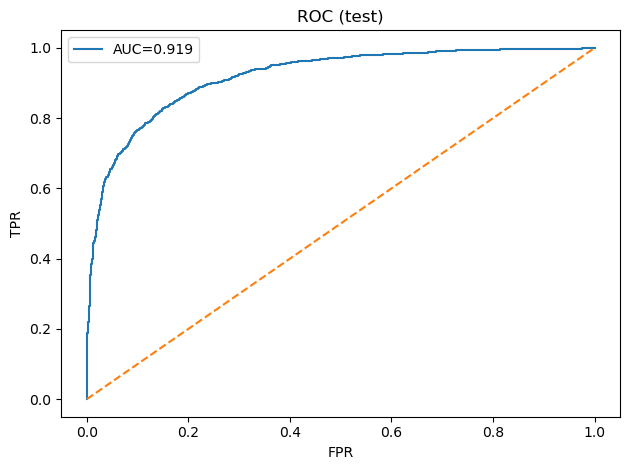

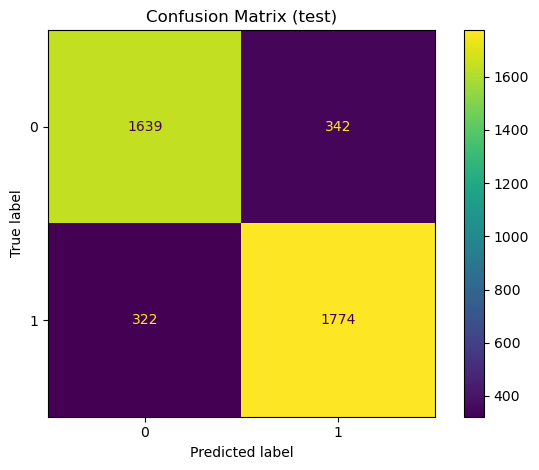

In [51]:
# ROC curve and confusion matrix

import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

pred = pred_tuned

pp = pred.select(
    scol("label").cast("int").alias("y"),
    vector_to_array(scol("probability")).getItem(1).alias("p"),
    scol("prediction").cast("int").alias("yhat")
).toPandas()

# ROC
fpr, tpr, _ = roc_curve(pp["y"], pp["p"])
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.legend(); plt.tight_layout(); plt.show()

# Confusion Matrix
cm = confusion_matrix(pp["y"], pp["yhat"])
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (test)")
plt.tight_layout(); plt.show()

In [52]:
# Hyperparameter tuning for LR (regParam, elasticNetParam)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr_base.regParam, [0.0, 0.001, 0.01, 0.1])
             .addGrid(lr_base.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

cv = CrossValidator(estimator=lr_base,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_roc,
                    numFolds=3,
                    parallelism=2)

cvModel = cv.fit(train)
pred_tuned = cvModel.transform(test)

print(f"Tuned     AUC-ROC={evaluator_roc.evaluate(pred_tuned):.3f}  "
      f"AUC-PR={evaluator_pr.evaluate(pred_tuned):.3f}  "
      f"ACC={m_acc.evaluate(pred_tuned):.3f}  F1={m_f1.evaluate(pred_tuned):.3f}")

best_lr = cvModel.bestModel
print("Best regParam:", best_lr._java_obj.getRegParam())
print("Best elasticNetParam:", best_lr._java_obj.getElasticNetParam())

Tuned     AUC-ROC=0.919  AUC-PR=0.925  ACC=0.837  F1=0.837
Best regParam: 0.0
Best elasticNetParam: 1.0


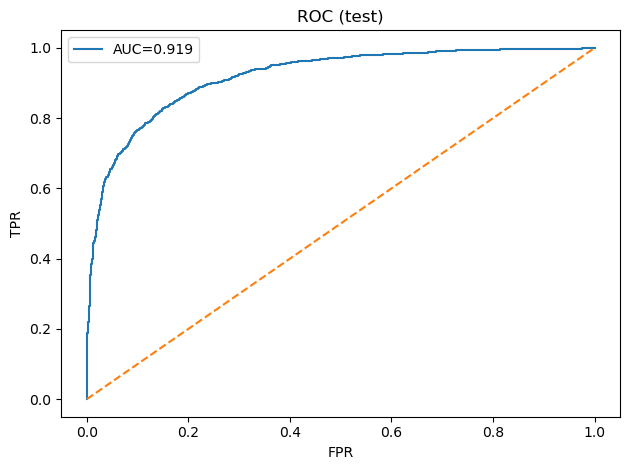

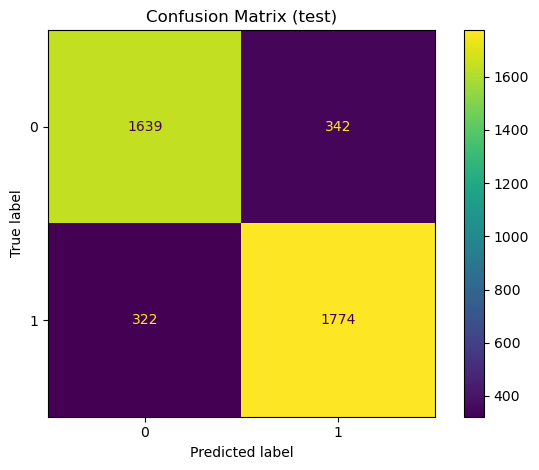

In [53]:
# Optional plots (requires Spark >= 3.1 for vector_to_array)
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

pred = pred_tuned  # or pred_base if you want to plot baseline

pp = pred.select(
    scol("label").cast("int").alias("y"),
    vector_to_array(scol("probability")).getItem(1).alias("p"),
    scol("prediction").cast("int").alias("yhat")
).toPandas()

fpr, tpr, _ = roc_curve(pp["y"], pp["p"])
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.legend(); plt.tight_layout(); plt.show()

cm = confusion_matrix(pp["y"], pp["yhat"])
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (test)")
plt.tight_layout(); plt.show()

In [54]:
spark.sparkContext.setLogLevel("ERROR")
spark.stop()